In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## understanding derivative with small function one input

In [2]:
def f(x):
    return 3*x**2-4*x+5

In [3]:
f(3)

20

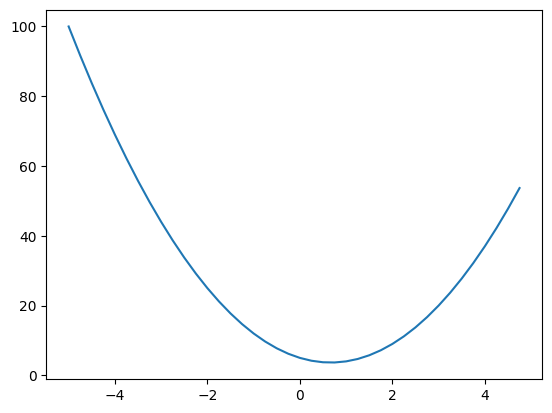

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = 3
(f(x+h)-f(x))/h

14.000300000063248

In [6]:
## try differentiating with a 
h = 0.001
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
d

4.0

In [25]:
#  differentiating d1 with a --> outputs b
h = 0.001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b +c
a = a+h
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope (or) differentiating d1 with a', (d2-d1)/h)
print('-'*100)

h = 0.001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b +c
b = b+h
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope (or) differentiating d1 with b', (d2-d1)/h)
print('-'*100)


h = 0.001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b +c
c =c+h
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope (or) differentiating d1 with c', (d2-d1)/h)
print('-'*100)


d1 4.0
d2 3.997
slope (or) differentiating d1 with a -3.0000000000001137
----------------------------------------------------------------------------------------------------
d1 4.0
d2 4.002
slope (or) differentiating d1 with b 1.9999999999997797
----------------------------------------------------------------------------------------------------
d1 4.0
d2 4.0009999999999994
slope (or) differentiating d1 with c 0.9999999999994458
----------------------------------------------------------------------------------------------------


## Implementing Value class

In [32]:
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        return Value(self.data+other.data)
    def __mul__(self, other):
        return Value(self.data*other.data)
    
a =  Value(2.0)
b =  Value(3.0)
a+b # python internally checks with the + operator and call the __add operator in the class like a.__add(b)
a*b # python internally checks with the * operator and call the __mul operator in the class like a.__mul(b)

Value(data=6.0)

In [33]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b+c

Value(data=4.0)

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.label = label
        self._op = _op
        self.grad = 0
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        top = []
        visited = set()
        def build_top(v):
            if v is not visited:
                visited.add(v)
                for child in v._prev:
                    build_top(child)
                top.append(v)
        build_top(self)
        self.grad = 1.0
        for node in reversed(top):
            node._backward()
            
    def __rmul__(self, other):  ## it handles 2*Value(3.0) cases by swapping elements
        return self*other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float"
        x = self.data
        out = Value(x**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (x**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def __sub__(self, other):
        return self+(-other)
    def __neg__(self):
        return self*-1
    def __radd__(self, other): # other + self
        return self + other
    def __rsub__(self, other): # other - self
        return other + (-self)

    
    
# build_top(o)
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'
f = Value(-2.0, label='f')

L = f*d
L.label = 'L'


print(d)
print(d._prev)
print(d._op)

Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}
+


In [8]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR= Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph create rectangular node of it
        dot.node(name=uid, label = "{%s | data %.4f | grad %.4f}" %(n.label, n.data, n.grad), shape='record')
        if n._op:
            # for the op node create the circle
            dot.node(name=uid+n._op, label=n._op)
            # connect node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
        
    return dot

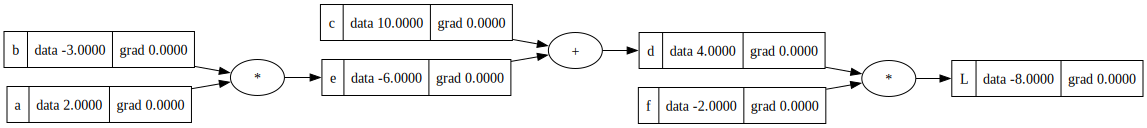

In [9]:
draw_dot(L)

## Calculate the loss 

In [ ]:
L = d*f

dL/dd = f = -2.0

(f(x+h)-f(x))/h
((d+h)*f - (df))/h --> (df+hf-df)/h --> hf/h --> f

similarly, dL/df = d = 4.0
--------------------------------------------------------------

dL/de = dL/dd * dd/de = -2.0

dd/de = 1

d = c+e
(f(x+h)-f(x))/h
((C+e+h)-(c+e))/h --> (c+e+h-c-e)/h --> 1.0
    (or)
dd/de = dd/dv + dd/de --> 0 + 1 --> 1.0

dL/de = dL/dd * dd/de --> (-2)*(1.0) --> (-2.0)

similarly, dd/dc = 1

dL/dc = dL/dd * dd/dc = -2.0
---------------------------------------------------------------

from above observations
dL/da = dL/de * de/da = (-2.0)*(-3.0) = 6.0
dL/db  = dL/de * de/db = (-2.0)*(2.0) = -4.0
de/da = b = -3.0
de/db = a = 2.0


In [10]:
def lol():
    h = 0.01
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e+c
    d.label = 'd'
    f = Value(-2.0, label='f')

    L1 = f*d
    L1 = L1.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e+c
    d.label = 'd'
    f = Value(-2.0, label='f')

    L2 = f*d
    L2 = L2.data+h
    print((L2-L1)/h)
lol()



0.9999999999999787


In [12]:
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
d.grad = -2.0
e.grad = -2.0
f.grad = 4.0
L.grad = 1.0

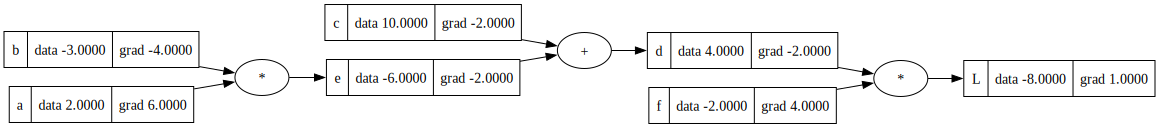

In [13]:
draw_dot(L)

## Activation or squashing function

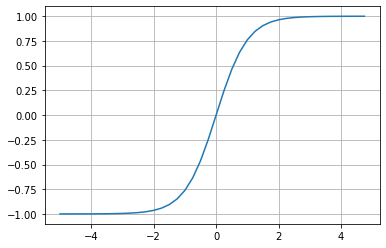

In [57]:

plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))
plt.grid()

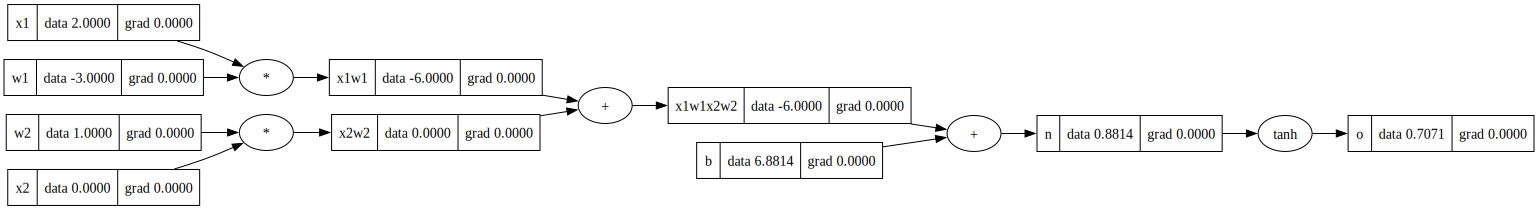

In [14]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label='x2')

## weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = w1*x1 
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'


x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1x2w2'

# x1*w1+x2*w2 +b
n = x1w1x2w2+b
n.label = 'n'
o = n.tanh()
o.label = 'o'
draw_dot(o)


In [15]:
o.grad = 1.0
# do/dn = derivative of tanh = (1-tanx**2) = (1-o.data**2) =  0.5000095900000001
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data*x1w1.grad
w1.grad = x1w1.grad*x1.data
x2.grad = w2.data*x2w2.grad
w2.grad = x2w2.grad*x2.data


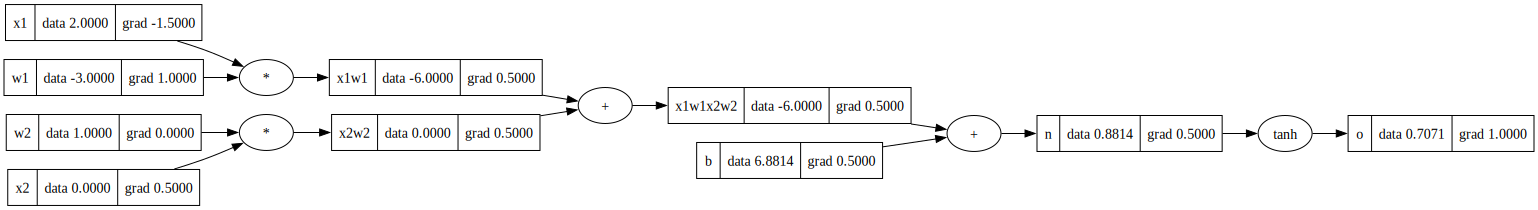

In [16]:
draw_dot(o)

## Implement _backward function in the code and run backward for every node to check

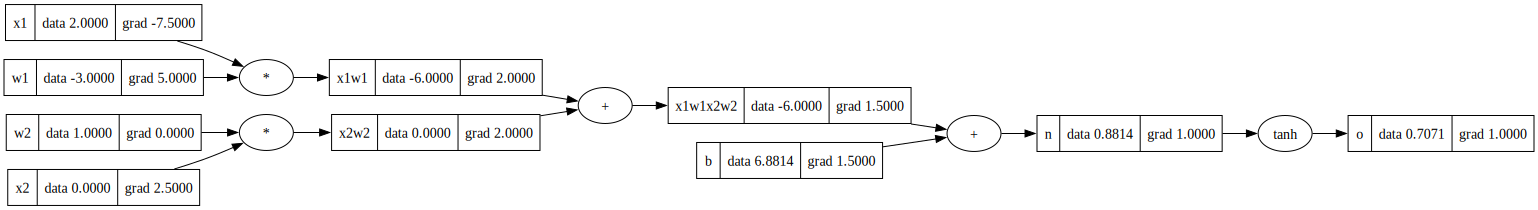

In [17]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

## Automate using topological graph

In [18]:
top = []
visited = set()
def build_top(v):
    if v is not visited:
        visited.add(v)
        for child in v._prev:
            build_top(child)
        top.append(v)
    return top
build_top(o)
            

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

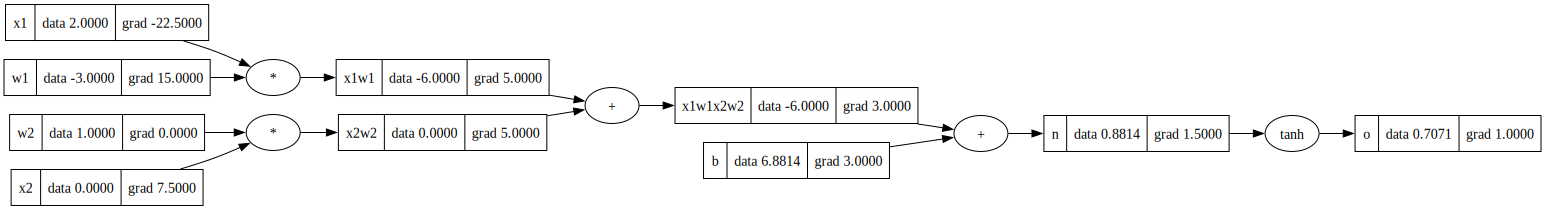

In [19]:
o.backward()
draw_dot(o)

## Adding Value support to other element to perform add and multiply operations with integer

In [20]:
a = Value(2.0)
a+1

Value(data=3.0)

In [21]:
# for division operation
# a/b => a*(b**-1)
a = Value(2.0)
b = Value(3.0)
a/b, a-b

(Value(data=0.6666666666666666), Value(data=-1.0))

## Splitting tanh function in above example

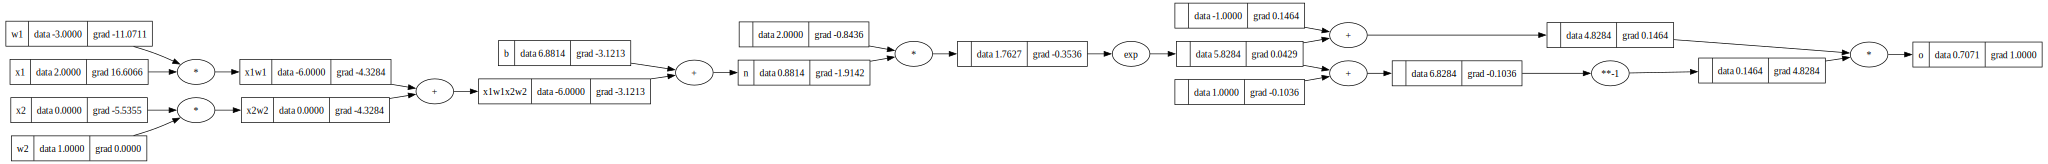

In [22]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label='x2')

## weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = w1*x1 
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'


x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1x2w2'

# x1*w1+x2*w2 +b
n = x1w1x2w2+b
n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)


## Compare our micrograd implementation with the pytorch implementation

In [120]:
import torch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1+x2*w2+b
# n.requires_grad = True
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('w1 grad', w1.grad.item())
print('w2 grad', w2.grad.item())
# print('n grad', n.grad.item())
print('x1 grad', x1.grad.item())
print('x2 grad', x2.grad.item())

0.7071066904050358
w1 grad 1.0000002567688737
w2 grad 0.0
x1 grad -1.5000003851533106
x2 grad 0.5000001283844369


In [126]:
n

tensor([0.8814], dtype=torch.float64, grad_fn=<AddBackward0>)

## Build MLP using the Value class

In [298]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))
    def __call__(self, x):
        out = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = out.tanh()
        return out
    def parameters(self):
        return self.w+[self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out)==1 else out
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nout):
        in_out = [nin]+nout  #[3, 4, 4, 1]
        self.layers = [Layer(in_out[i], in_out[i+1]) for i in range(len(nout))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

n = MLP(3, [4, 4, 1]) #32 neurons will be created as it is dense MLP
x = [2.0, 3.0, 4.0]
n(x)
# n

Value(data=-0.44827014005263655)

In [299]:
# draw_dot(n(x))

## Try to train above MLP using smaller numerical data

In [300]:
xs = [[2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [256]:
ypred = [n(i) for i in xs]
ypred

[Value(data=-0.6422848397232845),
 Value(data=-0.5242804756842688),
 Value(data=-0.6468918169354695),
 Value(data=-0.37454181168334455)]

In [257]:
loss = sum((pred-orig)**2 for pred, orig in zip(ypred, ys))
loss

Value(data=4.937459141612985)

In [258]:
loss.backward()

#### Gradient calculation --> w(j+1) = w(j) - (learning_rate)(dL/dw)

In [259]:
learning_rate = 0.01
for weights_biases in n.parameters():
    weights_biases.data = weights_biases.data-learning_rate*(weights_biases.grad)

In [275]:
## iterate the above process multiple times till loss closes to 0.

ypred = [n(i) for i in xs]
loss = sum((pred-orig)**2 for pred, orig in zip(ypred, ys))
print(loss)
loss.backward()
learning_rate = 0.01
for weights_biases in n.parameters():
    weights_biases.data = weights_biases.data-learning_rate*(weights_biases.grad)

Value(data=0.016574466320496393)


In [276]:
ypred 

[Value(data=0.9147967678305539),
 Value(data=-0.9676539542627041),
 Value(data=-0.9676355879165411),
 Value(data=0.9150226282824147)]

In [301]:
## Add toop with epochs count then it turns to the custom training 
learning_rate = 0.01
for epochs in range(20):
    
    ## forward pass
    ypred = [n(i) for i in xs]
    loss = sum((pred-orig)**2 for pred, orig in zip(ypred, ys))
    
    ## backward pass
    ## Make grads to zeros before calculating backward else it will end up summing 
    # the previous grads(refer Value class and see the grads updation script)
    for weights_biases in n.parameters():
        weights_biases.grad = 0.0
    
    loss.backward()
    
    # gradients update
    for weights_biases in n.parameters():
        weights_biases.data = weights_biases.data-learning_rate*(weights_biases.grad)
    print('Epochs and loss = ', epochs, loss)

Epochs and loss =  0 Value(data=3.7448684108648482)
Epochs and loss =  1 Value(data=2.037585136408602)
Epochs and loss =  2 Value(data=1.6044759655630885)
Epochs and loss =  3 Value(data=1.0504589139427924)
Epochs and loss =  4 Value(data=0.9301425767446794)
Epochs and loss =  5 Value(data=0.7427996528403149)
Epochs and loss =  6 Value(data=0.6095572468512275)
Epochs and loss =  7 Value(data=0.5308701888481866)
Epochs and loss =  8 Value(data=0.4637882891089602)
Epochs and loss =  9 Value(data=0.4125128762281952)
Epochs and loss =  10 Value(data=0.3727965756986516)
Epochs and loss =  11 Value(data=0.3250075299083405)
Epochs and loss =  12 Value(data=0.29648998144209504)
Epochs and loss =  13 Value(data=0.2770992655777951)
Epochs and loss =  14 Value(data=0.2601161848616601)
Epochs and loss =  15 Value(data=0.24063462851807751)
Epochs and loss =  16 Value(data=0.22428550662821645)
Epochs and loss =  17 Value(data=0.21200404763890113)
Epochs and loss =  18 Value(data=0.19720841626762506)